# An implementation of the Ant miner paper for Emotion Recognition

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv("Resources/Ravdess Dataset.csv")
df

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f643,f644,f645,f646,f647,f648,f649,f650,f651,class
0,-675.852,-820.630,-372.474,156.448,0.455,-1.471,68.959,-15.910,217.757,72.966,...,15.036,-3.957,32.880,0.023,-110.137,112.829,20.504,-0.442,17.036,neutral
1,-640.294,-783.178,-358.277,154.661,0.411,-1.555,64.627,-47.438,218.073,76.974,...,12.265,-4.655,30.513,-0.725,-82.309,67.398,13.982,-1.941,19.824,neutral
2,-677.497,-825.274,-375.799,157.171,0.415,-1.537,66.738,-79.028,208.915,73.381,...,22.398,-2.424,37.887,-0.037,-169.023,170.742,30.984,0.124,18.527,neutral
3,-659.499,-809.578,-356.445,164.199,0.455,-1.502,61.317,-70.403,214.674,75.767,...,10.528,1.095,18.721,-0.004,-59.714,50.999,13.634,-0.887,10.296,neutral
4,-698.072,-857.808,-409.923,156.816,0.281,-1.594,70.695,-55.799,221.357,70.646,...,24.944,-2.291,42.875,0.022,-253.151,210.330,35.594,-0.635,28.814,calm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,-528.333,-659.763,-241.697,164.582,0.572,-1.545,49.885,-36.404,205.386,69.445,...,14.937,1.440,10.757,-0.162,-69.727,107.401,18.274,1.613,15.420,surprised
1436,-609.369,-757.083,-307.215,179.786,0.575,-1.516,63.774,-32.482,223.057,77.018,...,10.696,0.127,1.252,-0.151,-39.864,30.325,10.742,-0.514,3.439,surprised
1437,-550.021,-686.908,-257.205,164.957,0.545,-1.525,57.948,-62.416,214.069,71.946,...,11.213,-0.678,3.609,-0.190,-46.936,48.720,11.619,0.666,5.487,surprised
1438,-559.621,-688.898,-280.156,160.536,0.578,-1.527,57.994,-17.436,206.204,75.294,...,14.703,-1.261,15.954,-0.240,-87.877,85.553,17.354,0.738,15.653,surprised


In [6]:
df.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f642,f643,f644,f645,f646,f647,f648,f649,f650,f651
count,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,...,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000
mean,-617.140585,-775.921906,-336.226018,153.577491,0.341140,-1.514376,66.080669,-50.311066,205.554483,67.663867,...,116.384694,18.968642,1.022901,27.146206,-0.014111,-135.996447,137.750953,25.960312,0.042112,16.677835
std,102.583020,110.019046,104.336146,14.627761,0.189282,0.159059,14.814138,31.428103,24.689521,10.262809,...,115.691859,16.561460,3.179686,22.008481,0.221524,127.161869,127.955980,23.661030,0.772542,11.039013
min,-873.242000,-1085.480000,-604.500000,102.684000,-0.699000,-1.822000,18.962000,-152.207000,126.251000,32.590000,...,6.710000,2.583000,-10.163000,0.181000,-1.169000,-542.389000,8.907000,3.219000,-3.329000,1.218000
25%,-693.680750,-851.702500,-412.092500,144.251750,0.232750,-1.622000,55.789000,-73.485750,188.831750,60.879250,...,35.468000,6.813500,-0.733000,11.926500,-0.070000,-184.060750,43.303000,9.162750,-0.287250,9.089250
50%,-622.875000,-781.136000,-337.006000,154.111500,0.351000,-1.537500,66.306000,-49.764500,206.224500,68.157500,...,65.210500,12.306500,0.970000,21.227500,-0.007000,-80.501000,83.417000,15.950000,0.044500,13.941000
75%,-551.599750,-704.343000,-269.011250,163.773000,0.471000,-1.432750,76.609000,-25.301750,222.685500,74.878750,...,149.218750,25.939250,2.693750,35.623500,0.041000,-43.780250,191.459000,34.499000,0.381250,21.289250
max,-333.378000,-461.489000,-27.451000,196.178000,0.908000,-0.423000,115.151000,28.868000,280.174000,91.064000,...,517.501000,104.955000,12.446000,157.084000,5.889000,-11.473000,593.229000,149.768000,9.310000,93.183000


In [39]:
#Level of discretization of the continuous data
bins = 20

(array([  5.,  10.,  20.,  41.,  98., 101., 136., 136., 134., 150., 138.,
        121.,  86.,  71.,  56.,  48.,  31.,  31.,  21.,   6.]),
 array([ 0.  ,  0.95,  1.9 ,  2.85,  3.8 ,  4.75,  5.7 ,  6.65,  7.6 ,
         8.55,  9.5 , 10.45, 11.4 , 12.35, 13.3 , 14.25, 15.2 , 16.15,
        17.1 , 18.05, 19.  ]),
 <BarContainer object of 20 artists>)

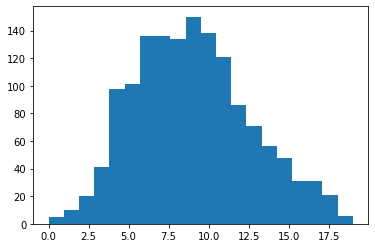

In [40]:
plt.hist(pd.cut(df['f0'], bins=bins, labels=range(bins)), bins = bins)

In [43]:
discreet = pd.DataFrame()

In [45]:
for column in df.drop('class', axis=1).columns:
    discreet[column] = pd.cut(df[column], bins=bins, labels=range(bins))

In [47]:
discreet['class'] = df['class']
discreet

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f643,f644,f645,f646,f647,f648,f649,f650,f651,class
0,7,8,8,11,14,5,10,15,11,13,...,2,5,4,3,16,3,2,4,3,neutral
1,8,9,8,11,13,3,9,11,11,15,...,1,4,3,1,17,2,1,2,4,neutral
2,7,8,7,11,13,4,9,8,10,13,...,3,6,4,3,14,5,3,5,3,neutral
3,7,8,8,13,14,4,8,9,11,14,...,1,9,2,3,18,1,1,3,1,neutral
4,6,7,6,11,12,3,10,10,12,13,...,4,6,5,3,10,6,4,4,6,calm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,12,13,12,13,15,3,6,12,10,12,...,2,10,1,2,17,3,2,7,3,surprised
1436,9,10,10,16,15,4,9,13,12,15,...,1,9,0,2,18,0,1,4,0,surprised
1437,11,12,12,13,15,4,8,9,11,13,...,1,8,0,2,18,1,1,6,0,surprised
1438,11,12,11,12,15,4,8,14,10,14,...,2,7,2,2,17,2,1,6,3,surprised
